
# Intro to the sift
This tutorial is a general introduction to the sift algorithm. We introduce the
sift in steps and some of the options that can be tuned.


In [1]:
# Uncomment and run this if you're environment doesn't contain EMD already - eg if running on colab.
#!pip install emd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.0 MB/s eta 0:00:00


Lets make a simulated signal to get started. This is a fairly complicated
signal with a non-linear 12Hz oscillation, a very slow fluctuation and some
high frequency noise.



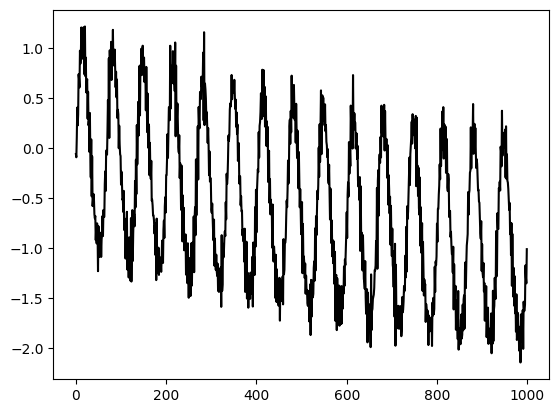

In [2]:
import emd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


sample_rate = 1000
seconds = 1
num_samples = sample_rate*seconds
time_vect = np.linspace(0, seconds, num_samples)
freq = 15

# Change extent of deformation from sinusoidal shape [-1 to 1]
nonlinearity_deg = .25

# Change left-right skew of deformation [-pi to pi]
nonlinearity_phi = -np.pi/4

# Create a non-linear oscillation
x = emd.simulate.abreu2010(freq, nonlinearity_deg, nonlinearity_phi, sample_rate, seconds)

x -= np.sin(2 * np.pi * 0.22 * time_vect)   # Add part of a very slow cycle as a trend

# Add a little noise - with low frequencies removed to make this example a
# little cleaner...
np.random.seed(42)
n = np.random.randn(1000,) * .2
nf = signal.savgol_filter(n, 3, 1)
n = n - nf

x = x + n

plt.figure()
plt.plot(x, 'k')

# sphinx_gallery_thumbnail_number = 8

The sift works by iteratively extracting oscillatory components from a
signal. Starting from the fastest and through to the very slowest until only
a non-oscillatory trend is left. Each component is then known as an
'Intrinsic Mode Function' or IMF.

The extraction of these IMFs is a difficult problem without a clear analytic
or symbolic solution. Therefore, the sift looks to iteratively approximate
the best set of IMFs using a set of heuristic rules (this sort of analysis is
a type of numerical algorithm).

The first thing the sift does is identify the very fastest dynamics in a
signal. We do this by identifying all the peaks and troughs in the signal.
Here, we do this with ``emd.sift.get_padded_extrema`` and plot the extrema on
a segment of the signal.



(0.0, 150.0)

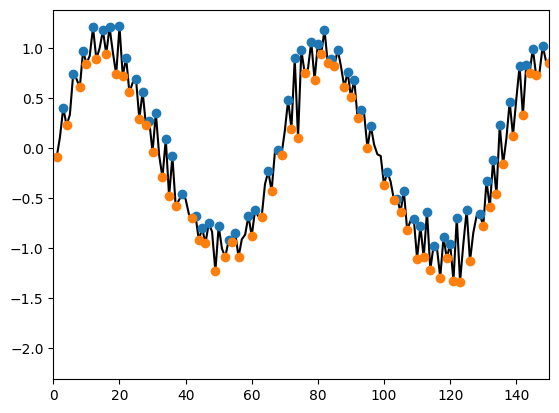

In [3]:
peak_locs, peak_mags = emd.sift.get_padded_extrema(x, pad_width=0, mode='peaks')
trough_locs, trough_mags = emd.sift.get_padded_extrema(x, pad_width=0, mode='troughs')

plt.figure()
plt.plot(x, 'k')
plt.plot(peak_locs, peak_mags, 'o')
plt.plot(trough_locs, trough_mags, 'o')
plt.xlim(0, 150)

We want to extract the fastest dynamics from this signal - but what do we
mean by fastest? We define the fastest dynamics to be the oscillations
occurring between adjacent peaks and troughs in our signal - anything slower
should be removed for now.

To isolate these fast dynamics, we identify an upper and lower amplitude
envelope from the peaks and troughs and compute their average. Here we do
this with ``emd.sift.interp_envelope`` (note: this uses
``emd.sift.get_padded_extrema`` internally to find the same extrema we
plotted above) and then plot an example.



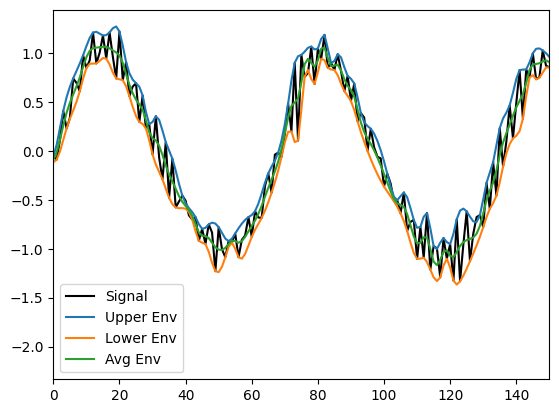

In [4]:
proto_imf = x.copy()
# Compute upper and lower envelopes
upper_env = emd.sift.interp_envelope(proto_imf, mode='upper')
lower_env = emd.sift.interp_envelope(proto_imf, mode='lower')

# Compute average envelope
avg_env = (upper_env+lower_env) / 2

plt.figure()
plt.plot(x, 'k')
plt.plot(upper_env)
plt.plot(lower_env)
plt.plot(avg_env)
plt.xlim(0, 150)
plt.legend(['Signal', 'Upper Env', 'Lower Env', 'Avg Env'])

In this segment, we can see that the fastest dynamics occur in the rapid
oscillations of the black line between its upper a lower envelope. These
oscillations are happening alongside dynamics on other time-scales which are
all summed together to make the original signal. We approximate these slower
dynamics through the average of the uppers and lower envelope - the green
line in the plot above). The average envelope drifts more slowly than the
fastest oscillations visible in the raw signal and tends to capture trends in
the mean across several cycles of the fastest dynamics.

We can remove these slower components by simply subtracting this average
envelope. Here we do this subtraction and make a quick plot



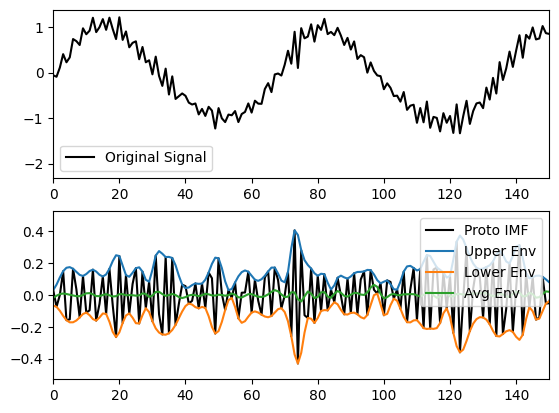

In [5]:
# Subtract slow dynamics from previous cell
proto_imf = x - avg_env

# Compute upper and lower envelopes
upper_env = emd.sift.interp_envelope(proto_imf, mode='upper')
lower_env = emd.sift.interp_envelope(proto_imf, mode='lower')

# Compute average envelope
avg_env = (upper_env+lower_env) / 2

plt.figure()
plt.subplot(211)
plt.plot(x, 'k')
plt.xlim(0, 150)
plt.legend(['Original Signal'])

plt.subplot(212)
plt.plot(proto_imf, 'k')
plt.plot(upper_env)
plt.plot(lower_env)
plt.plot(avg_env)
plt.xlim(0, 150)
plt.legend(['Proto IMF', 'Upper Env', 'Lower Env', 'Avg Env'])

The top panel shows the original signal and average envelope, and the bottom
panel shows the signal with the average envelope removed and the envelopes of
this new signal.

The fastest oscillations are now much clearer with the slow trends removed.
The sift algorithm now just repeats these steps until certain stopping
conditions are met. In general, we want to stop sifting an IMF once the
average of the upper and lower envelopes are sufficiently close to zero.
When this condition is met, it guarantees that the signal will behave well
during analysis of instantaneous frequency (a story for another tutorial...).

Here we run another iteration of the sift on the residual of our previous one.



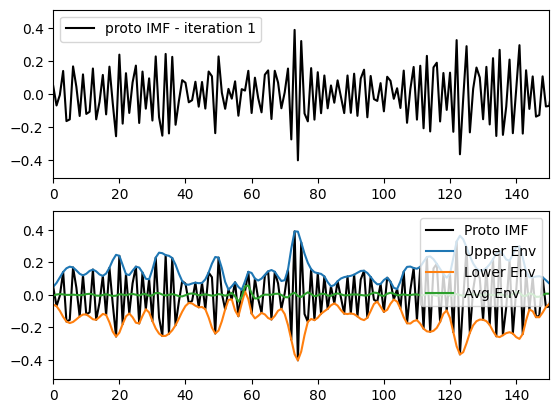

In [6]:
# Subtract slow dynamics from previous cell
proto_imf = proto_imf - avg_env

# Compute upper and lower envelopes
upper_env = emd.sift.interp_envelope(proto_imf, mode='upper')
lower_env = emd.sift.interp_envelope(proto_imf, mode='lower')

# Compute average envelope
avg_env = (upper_env+lower_env) / 2

plt.figure()
plt.subplot(211)
plt.plot(proto_imf, 'k')
plt.xlim(0, 150)
plt.legend(['proto IMF - iteration 1'])

plt.subplot(212)
plt.plot(proto_imf, 'k')
plt.plot(upper_env)
plt.plot(lower_env)
plt.plot(avg_env)
plt.xlim(0, 150)
plt.legend(['Proto IMF', 'Upper Env', 'Lower Env', 'Avg Env'])

After two iterations the average envelope is now very closer to zero though
there are still some deviations. The full sift would continue iterating until
we pass a defined threshold and accept the result as our IMF.




## Running sift iterations



We don't want to run these iterations by hand, so lets define a function to
do the work for us. Here, we make ``my_get_next_imf`` which will repeat the
steps above until the average envelopes are sufficiently close to zero as
defined by the ``sd_thresh``. We will plot the sift ierations as we go and
include an option to zoom in in part of the signal.



In [7]:
def my_get_next_imf(x, zoom=None, sd_thresh=0.1):

    proto_imf = x.copy()  # Take a copy of the input so we don't overwrite anything
    continue_sift = True  # Define a flag indicating whether we should continue sifting
    niters = 0            # An iteration counter

    if zoom is None:
        zoom = (0, x.shape[0])

    # Main loop - we don't know how many iterations we'll need so we use a ``while`` loop
    while continue_sift:
        niters += 1  # Increment the counter

        # Compute upper and lower envelopes
        upper_env = emd.sift.interp_envelope(proto_imf, mode='upper')
        lower_env = emd.sift.interp_envelope(proto_imf, mode='lower')

        # Compute average envelope
        avg_env = (upper_env+lower_env) / 2

        # Add a summary subplot
        plt.subplot(5, 1, niters)
        plt.plot(proto_imf[zoom[0]:zoom[1]], 'k')
        plt.plot(upper_env[zoom[0]:zoom[1]])
        plt.plot(lower_env[zoom[0]:zoom[1]])
        plt.plot(avg_env[zoom[0]:zoom[1]])

        # Should we stop sifting?
        stop, val = emd.sift.sd_stop(proto_imf-avg_env, proto_imf, sd=sd_thresh)

        # Remove envelope from proto IMF
        proto_imf = proto_imf - avg_env

        # and finally, stop if we're stopping
        if stop:
            continue_sift = False

    # Return extracted IMF
    return proto_imf

The core parts of this function should be familiar from earlier parts of the
tutorial. We can now call this function to find the fastest IMF from our
signal.

Let's extract our IMF, plotting the iterations and zooming in to a 100 sample
period so we can see the details.



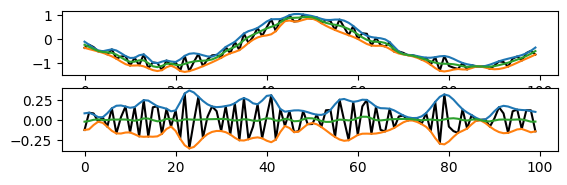

In [8]:
imf1 = my_get_next_imf(x, zoom=(100, 200))

The top panel shows the original signal and each lower panel shows successive
iterations. The first iteration removes the majority of the slow oscillation
whilst the second does some fine-tuning.

Here we plot the original signal, the first IMF and the residual after
subtracting the first IMF from the signal.



([], [])

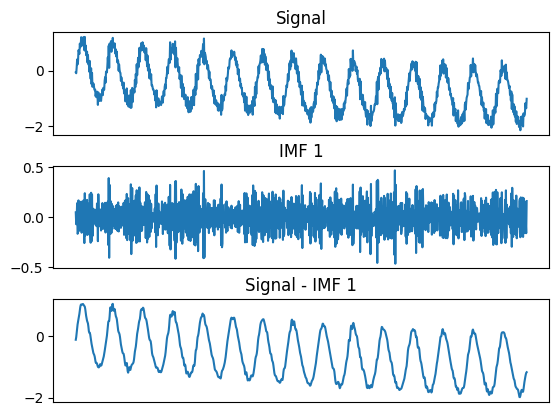

In [9]:
plt.figure()
plt.subplots_adjust(hspace=0.3)

plt.subplot(311)
plt.plot(x)
plt.title('Signal')
plt.xticks([])

plt.subplot(312)
plt.plot(imf1)
plt.title('IMF 1')
plt.xticks([])

plt.subplot(313)
plt.plot(x - imf1)
plt.title('Signal - IMF 1')
plt.xticks([])

There are some edge effects visible in our IMF. This is due to uncertainty in
the envelope interpolation at the edges of the signal. The residual of the
signal minus the IMF now has a lot of high frequency content removed.

We can repeat the process on this residual to identify our next IMF. The
process of peak detection, envelope interpolation and subtraction is
identical for this second IMF. Critically, as we've removed the first IMF -
the peaks will be further apart in this iteration and we will extract slower
dynamics. Therefore we zoom into a slightly longer 200 sample window.



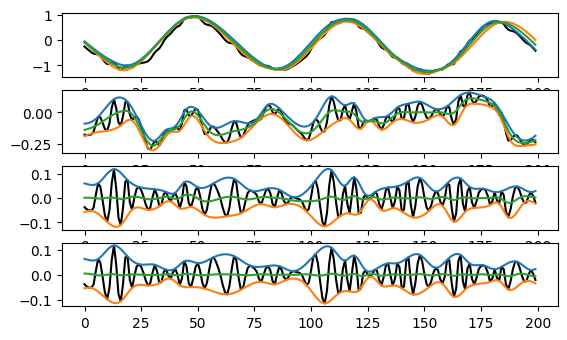

In [10]:
imf2 = my_get_next_imf(x - imf1, zoom=(100, 300))

This IMF is tiny! The first couple of iterations remove the big slow
oscillations and after four iterations we have a very small amplitude
component containing a clean oscillation with zero mean.

After subtracting both IMFs the larger 12 Hz oscillation now looks very
smooth.



([], [])

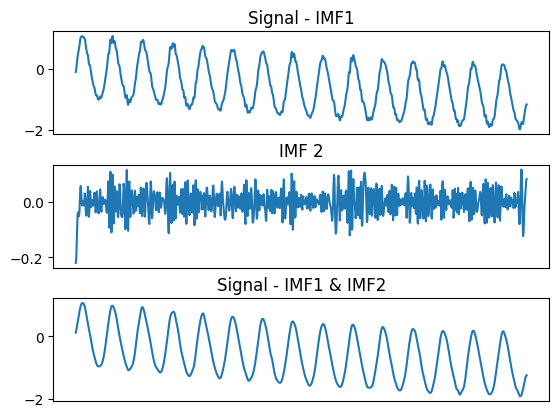

In [11]:
plt.figure()
plt.subplots_adjust(hspace=0.3)

plt.subplot(311)
plt.plot(x - imf1)
plt.title('Signal - IMF1')
plt.xticks([])

plt.subplot(312)
plt.plot(imf2)
plt.title('IMF 2')
plt.xticks([])

plt.subplot(313)
plt.plot(x - imf1 - imf2)
plt.title('Signal - IMF1 & IMF2')
plt.xticks([])

The next IMF extraction is very simple. It only takes a single iteration to
remove the slow drift from the 12Hz oscillation



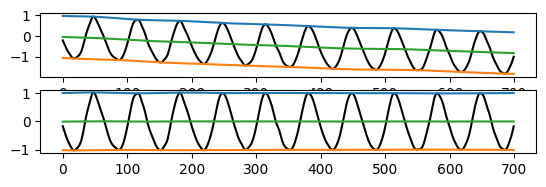

In [12]:
imf3 = my_get_next_imf(x - imf1 - imf2, zoom=(100, 800))

The residual of the signal with the first 3 IMFs is now close to a trend.



([], [])

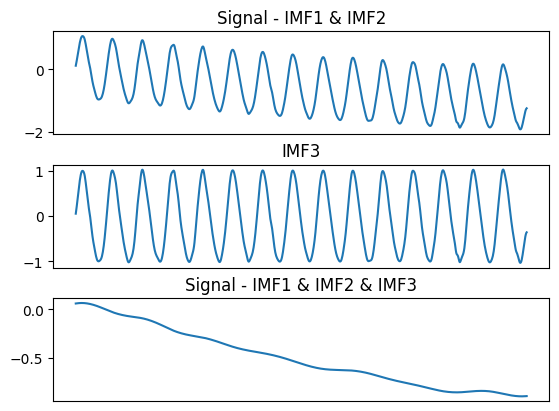

In [13]:
plt.figure()
plt.subplots_adjust(hspace=0.3)

plt.subplot(311)
plt.plot(x - imf1 - imf2)
plt.title('Signal - IMF1 & IMF2')
plt.xticks([])

plt.subplot(312)
plt.plot(imf3)
plt.title('IMF3')
plt.xticks([])

plt.subplot(313)
plt.plot(x - imf1 - imf2 - imf3)
plt.title('Signal - IMF1 & IMF2 & IMF3')
plt.xticks([])

## The top-level sift function



This whole process is implemented in ``emd.sift.sift``. Here we run the sift
using the top level function and recover the same components as we generated
during this tutorial.



<Axes: xlabel='Time (samples)'>

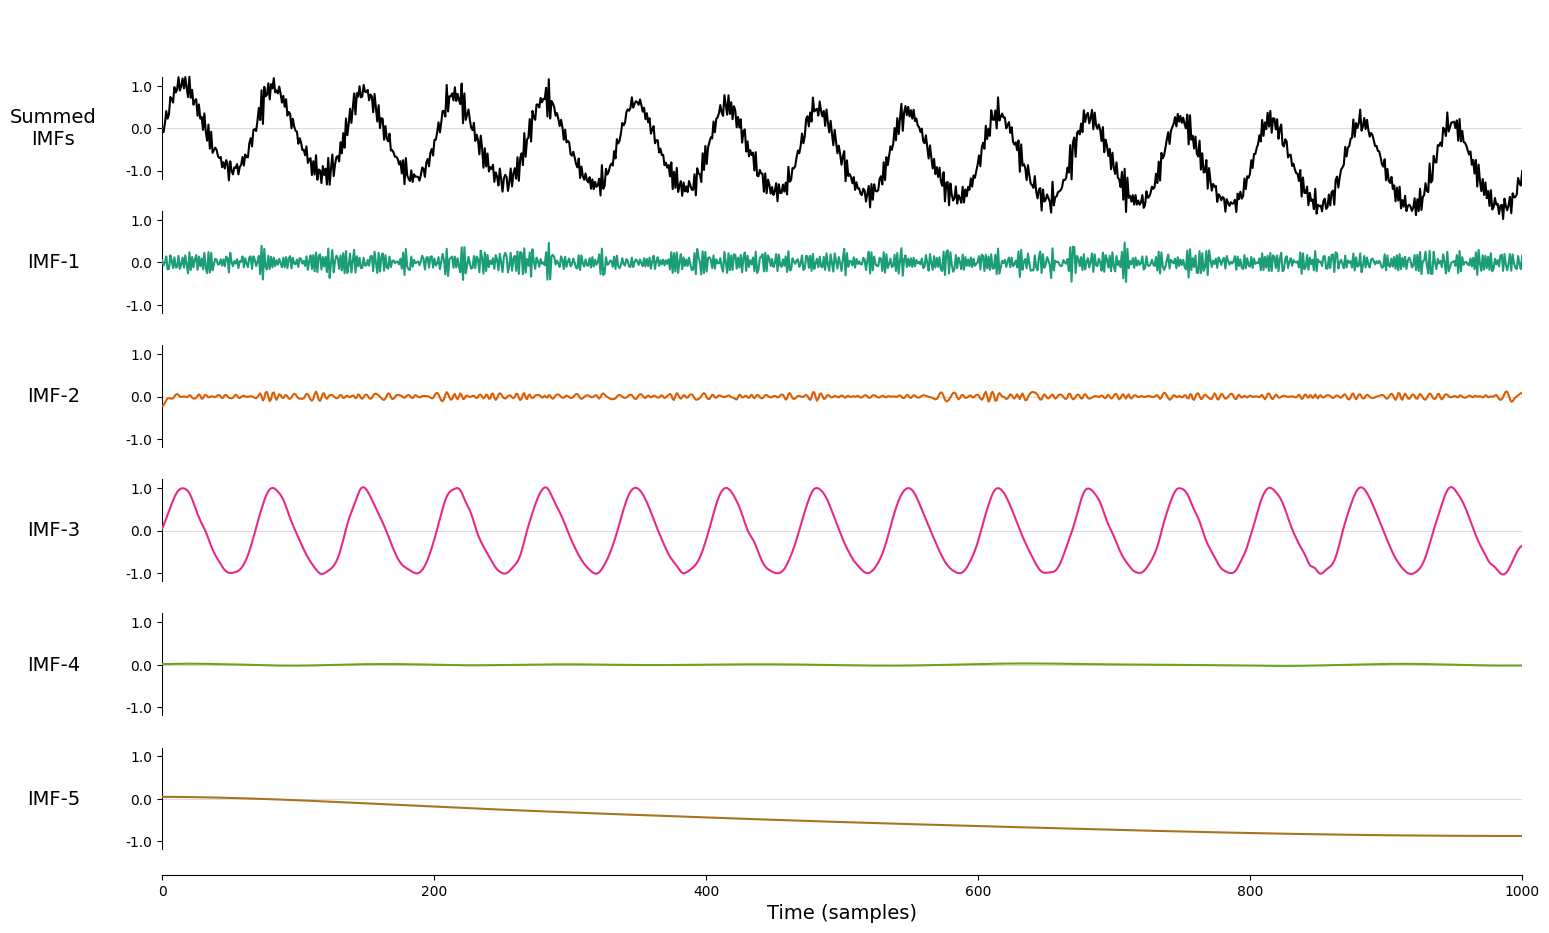

In [15]:
imf = emd.sift.sift(x, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf)

``emd.sift.sift`` is highly customisable with many options tuning the peak
detection, envelope interpolation and sift thresholds.



## Further Reading & References



Huang, N. E., Shen, Z., Long, S. R., Wu, M. C., Shih, H. H., Zheng, Q., … Liu, H. H. (1998).
The empirical mode decomposition and the Hilbert spectrum for nonlinear and
non-stationary time series analysis. Proceedings of the Royal Society of
London. Series A: Mathematical, Physical and Engineering Sciences, 454(1971), 903–995.
https://doi.org/10.1098/rspa.1998.0193

